In [1]:
import os
import glob
from glob import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau


2025-09-19 17:23:52.316415: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758302632.490049    2961 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758302632.536991    2961 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Check GPU

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:        # Enable memory growth for each GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"{len(gpus)} GPU(s) detected and memory growth enabled.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected, running on CPU.")

print("Default device:", tf.test.gpu_device_name())


1 GPU(s) detected and memory growth enabled.
Default device: /device:GPU:0


I0000 00:00:1758302638.802134    2961 gpu_device.cc:2022] Created device /device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


## Load Dataset

In [3]:
IMG_SIZE = 224

def load_dataset(image_dir, mask_dir, img_size=IMG_SIZE):
    image_paths = sorted(glob(os.path.join(image_dir, '*.jpg'))) 
    mask_paths  = sorted(glob(os.path.join(mask_dir, '*.png')))  

    images, masks = [], []

    for img_path, mask_path in zip(image_paths, mask_paths):
        img_bgr  = cv2.imread(img_path)
        img_rgb  = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        img_res  = cv2.resize(img_rgb, (img_size, img_size), interpolation=cv2.INTER_AREA)
        img_norm = (img_res / 255.0).astype(np.float32)
        images.append(img_norm)

        mask      = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask_res  = cv2.resize(mask, (img_size, img_size), interpolation=cv2.INTER_NEAREST)
        # binarize to {0,1}
        mask_bin  = (mask_res > 127).astype(np.float32)
        mask_exp  = np.expand_dims(mask_bin, axis=-1)  # (H, W, 1)
        masks.append(mask_exp)

    return np.array(images, dtype=np.float32), np.array(masks, dtype=np.float32)

# Load datasets
data = np.load("/kaggle/input/segmenttraindata/train_data.npz")
train_images, train_masks = data["images"], data["masks"]
"""
train_images, train_masks = load_dataset(
    image_dir = "/kaggle/input/segmentation/dataset_split/train/images",
    mask_dir  = "/kaggle/input/segmentation/dataset_split/train/masks",
    img_size  = IMG_SIZE
)"""

val_images, val_masks = load_dataset(
    image_dir = "/kaggle/input/segmentation/dataset_split/val/images",
    mask_dir  = "/kaggle/input/segmentation/dataset_split/val/masks",
    img_size  = IMG_SIZE
)

test_images, test_masks = load_dataset(
    image_dir = "/kaggle/input/segmentation/dataset_split/test/images",
    mask_dir  = "/kaggle/input/segmentation/dataset_split/test/masks",
    img_size  = IMG_SIZE
)

print("Train:", train_images.shape, train_masks.shape)
print("Val:", val_images.shape, val_masks.shape)
print("Test:", test_images.shape, test_masks.shape)


Train: (8012, 224, 224, 3) (8012, 224, 224, 1)
Val: (1001, 224, 224, 3) (1001, 224, 224, 1)
Test: (1002, 224, 224, 3) (1002, 224, 224, 1)


In [4]:
BATCH_SIZE = 16
IMG_SIZE = 224

# Convert numpy arrays to tf.data.Dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
val_ds   = tf.data.Dataset.from_tensor_slices((val_images, val_masks))

# Augment function
def augment(image, mask):
    # Geometric transforms (apply to both image & mask)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask  = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask  = tf.image.flip_up_down(mask)

    # Random 90° rotation (0, 90, 180, 270)
    k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    mask  = tf.image.rot90(mask, k)

    # Photometric transforms (apply to image only)
    image = tf.image.random_brightness(image, 0.05)   # lighter than before
    image = tf.image.random_contrast(image, 0.95, 1.05)

    # Clip to [0,1] to avoid weird colors
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, mask

# Apply to dataset
train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(512).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
train_ds = train_ds.repeat()

val_ds   = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

I0000 00:00:1758302684.627118    2961 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

def augment_all_versions(image, mask):
    """Generate multiple fixed augmentations from one (image, mask)."""

    # Ensure float32 in [0,1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    mask  = tf.image.convert_image_dtype(mask, tf.float32)

    versions = []

    # Original
    versions.append(("Original", image, mask))

    # Flip left-right
    versions.append(("Flip LR", tf.image.flip_left_right(image), 
                                tf.image.flip_left_right(mask)))

    # Flip up-down
    versions.append(("Flip UD", tf.image.flip_up_down(image), 
                                tf.image.flip_up_down(mask)))

    # Rotate 90, 180, 270
    for k, deg in zip([1,2,3], ["Rotate 90°","Rotate 180°","Rotate 270°"]):
        versions.append((deg, tf.image.rot90(image, k=k), 
                              tf.image.rot90(mask, k=k)))

    # Brightness
    versions.append(("Brightness", tf.image.random_brightness(image, max_delta=0.2), mask))

    # Contrast
    versions.append(("Contrast", tf.image.random_contrast(image, 0.8, 1.2), mask))

    # Zoom (central crop then resize back)
    crop = tf.image.central_crop(image, central_fraction=0.8)
    crop = tf.image.resize(crop, (image.shape[0], image.shape[1]))
    versions.append(("Zoom", crop, mask))

    return versions


def show_all_augments(image, mask):
    versions = augment_all_versions(image, mask)

    plt.figure(figsize=(16, 8))
    for i, (name, img, msk) in enumerate(versions):
        img_disp = img.numpy()
        img_disp = (img_disp * 255).astype(np.uint8)

        msk_disp = msk.numpy().squeeze()
        msk_disp = (msk_disp * 255).astype(np.uint8)

        # Image
        plt.subplot(2, len(versions), i+1)
        plt.imshow(img_disp)
        plt.axis("off")
        plt.title(name)

        # Mask
        plt.subplot(2, len(versions), i+1+len(versions))
        plt.imshow(msk_disp, cmap="gray")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# Example: take the first sample
sample_img = tf.convert_to_tensor(train_images[0], dtype=tf.float32)
sample_msk = tf.convert_to_tensor(train_masks[0], dtype=tf.float32)

show_all_augments(sample_img, sample_msk)


## Code Block for saving data as .npz file. (Helps load dataset quicker, especially on kaggle)

In [6]:
#np.savez_compressed("train_data.npz", images=train_images, masks=train_masks)

## Test to see image and mask sync


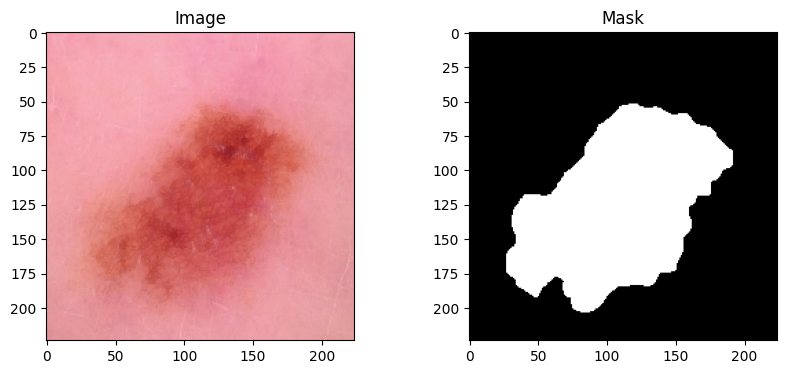

In [7]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(train_images[5])
plt.title("Image")

plt.subplot(1, 2, 2)
plt.imshow(train_masks[5].squeeze(), cmap='gray')
plt.title("Mask")
plt.show()


# Build U-Net Model

In [8]:
def conv_block(x, filters, dropout=0.0):
    """Conv → BN → ReLU → Conv → BN → ReLU → (optional dropout)"""
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    if dropout > 0:
        x = layers.Dropout(dropout)(x)
    return x

def build_unet(input_shape=(224, 224, 3)):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = conv_block(inputs, 16, dropout=0.1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 32, dropout=0.1)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 64, dropout=0.2)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, 128, dropout=0.2)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck (deeper than before)
    c5 = conv_block(p4, 256, dropout=0.3)

    # Decoder
    u6 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(c5)
    u6 = layers.Concatenate()([u6, c4])
    c6 = conv_block(u6, 128)

    u7 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(c6)
    u7 = layers.Concatenate()([u7, c3])
    c7 = conv_block(u7, 64)

    u8 = layers.Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(c7)
    u8 = layers.Concatenate()([u8, c2])
    c8 = conv_block(u8, 32)

    u9 = layers.Conv2DTranspose(16, 2, strides=(2, 2), padding='same')(c8)
    u9 = layers.Concatenate()([u9, c1])
    c9 = conv_block(u9, 16)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c9)

    model = Model(inputs, outputs, name="Improved_U-Net")
    return model

In [9]:
"""def build_unet(input_shape=(224, 224, 3)):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(16, 3, padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Activation('relu')(c1)

    c1 = layers.Conv2D(16, 3, padding='same')(c1)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Activation('relu')(c1)
    
    c1 = layers.Dropout(0.1)(c1)  #  Dropout 


    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = layers.Conv2D(128, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(128, 3, activation='relu', padding='same')(c4)

    # Decoder
    u5 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(c4)
    u5 = layers.Concatenate()([u5, c3])
    c5 = layers.Conv2D(64, 3, activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(64, 3, activation='relu', padding='same')(c5)

    u6 = layers.Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(c5)
    u6 = layers.Concatenate()([u6, c2])
    c6 = layers.Conv2D(32, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(32, 3, activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(16, 2, strides=(2, 2), padding='same')(c6)
    u7 = layers.Concatenate()([u7, c1])
    c7 = layers.Conv2D(16, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(16, 3, activation='relu', padding='same')(c7)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c7)

    model = Model(inputs, outputs)  
    return model"""

"def build_unet(input_shape=(224, 224, 3)):\n    inputs = layers.Input(input_shape)\n\n    # Encoder\n    c1 = layers.Conv2D(16, 3, padding='same')(inputs)\n    c1 = layers.BatchNormalization()(c1)\n    c1 = layers.Activation('relu')(c1)\n\n    c1 = layers.Conv2D(16, 3, padding='same')(c1)\n    c1 = layers.BatchNormalization()(c1)\n    c1 = layers.Activation('relu')(c1)\n    \n    c1 = layers.Dropout(0.1)(c1)  #  Dropout \n\n\n    p1 = layers.MaxPooling2D((2, 2))(c1)\n\n    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)\n    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)\n    p2 = layers.MaxPooling2D((2, 2))(c2)\n\n    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)\n    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)\n    p3 = layers.MaxPooling2D((2, 2))(c3)\n\n    # Bottleneck\n    c4 = layers.Conv2D(128, 3, activation='relu', padding='same')(p3)\n    c4 = layers.Conv2D(128, 3, activation='relu', padding='same')(c4

In [10]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    
def iou_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    d_loss = dice_loss(y_true, y_pred)
    return bce + d_loss


## Model Compile & Summary

In [11]:
model = build_unet()
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=['accuracy', dice_coef, iou_coef])
#model.summary()

In [12]:
"""import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

# ✅ Multi-GPU strategy (will use all GPUs if more than 1)
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = build_unet()
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', dice_coef, iou_coef]
    )

#model.summary()"""

"import tensorflow as tf\nfrom tensorflow.keras.callbacks import ModelCheckpoint\n\n# ✅ Multi-GPU strategy (will use all GPUs if more than 1)\nstrategy = tf.distribute.MirroredStrategy()\n\nwith strategy.scope():\n    model = build_unet()\n    model.compile(\n        optimizer='adam',\n        loss='binary_crossentropy',\n        metrics=['accuracy', dice_coef, iou_coef]\n    )\n\n#model.summary()"

## Test performance B4 training

In [13]:
test_loss, test_acc, test_dice, test_iou = model.evaluate(test_images, test_masks)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)
print("Test Dice Coefficient:", test_dice)
print("Test IoU:", test_iou)

I0000 00:00:1758302708.041564    2994 service.cc:148] XLA service 0x78f08c060260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758302708.042326    2994 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758302708.344251    2994 cuda_dnn.cc:529] Loaded cuDNN version 90300


 5/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.3195 - dice_coef: 0.3157 - iou_coef: 0.1878 - loss: 1.3813

I0000 00:00:1758302712.614581    2994 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.3394 - dice_coef: 0.3391 - iou_coef: 0.2046 - loss: 1.3577
Test Loss: 1.3527889251708984
Test Accuracy: 0.3469698131084442
Test Dice Coefficient: 0.3449748158454895
Test IoU: 0.2089497298002243


## Train Section

In [14]:
# ✅ Checkpoint callback
checkpoint = ModelCheckpoint(
    filepath='/kaggle/working/best_model.h5',
    monitor='val_dice_coef',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Reduce LR when validation loss stops improving
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',   # what to watch
    factor=0.5,           # reduce LR by this factor
    patience=5,           # wait this many epochs before reducing
    verbose=1,
    min_lr=1e-6
)

history = model.fit(
    train_ds,
    steps_per_epoch=len(train_images)//BATCH_SIZE,
    validation_data=val_ds,
    validation_steps=len(val_images)//BATCH_SIZE,
    epochs=50,
    callbacks=[checkpoint, lr_scheduler]
)

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8521 - dice_coef: 0.6265 - iou_coef: 0.4679 - loss: 0.7796
Epoch 1: val_dice_coef improved from -inf to 0.80386, saving model to /kaggle/working/best_model.h5
500/500 ━━━━━━━━━━━━━━━━━━━━ 76s 72ms/step - accuracy: 0.8522 - dice_coef: 0.6267 - iou_coef: 0.4681 - loss: 0.7791 - val_accuracy: 0.9309 - val_dice_coef: 0.8039 - val_iou_coef: 0.6736 - val_loss: 0.4065 - learning_rate: 0.0010
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9394 - dice_coef: 0.8480 - iou_coef: 0.7375 - loss: 0.3216
Epoch 2: val_dice_coef improved from 0.80386 to 0.84060, saving model to /kaggle/working/best_model.h5
500/500 ━━━━━━━━━━━━━━━━━━━━ 48s 69ms/step - accuracy: 0.9394 - dice_coef: 0.8481 - iou_coef: 0.7375 - loss: 0.3215 - val_accuracy: 0.9402 - val_dice_coef: 0.8406 - val_iou_coef: 0.7270 - val_loss: 0.3278 - learning_rate: 0.0010
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9472 - dice_coef: 0.

## Test performance after training

In [15]:
# Evaluate the model
test_results = model.evaluate(test_images, test_masks)

# Print all metrics
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])
print("Test Dice Coefficient:", test_results[2])
print("Test IoU:", test_results[3])

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9640 - dice_coef: 0.9166 - iou_coef: 0.8463 - loss: 0.1846
Test Loss: 0.182351753115654
Test Accuracy: 0.9644654393196106
Test Dice Coefficient: 0.918861985206604
Test IoU: 0.8503223061561584


## Evaluate and Plot Loss & Dice

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9640 - dice_coef: 0.9166 - iou_coef: 0.8463 - loss: 0.1846


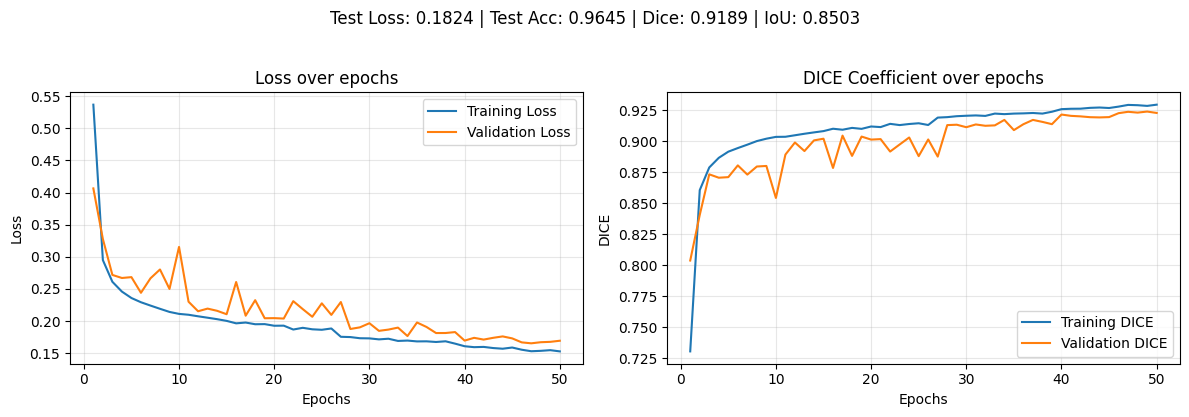

In [16]:
# Evaluate the model
test_results = model.evaluate(test_images, test_masks)
test_loss, test_acc, test_dice, test_iou = test_results

# Build epoch index (helps when history logs begin at epoch 1)
epochs = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(12, 4))

# LEFT: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# RIGHT: DICE  (note: keys use your metric function name)
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['dice_coef'], label='Training DICE')
plt.plot(epochs, history.history['val_dice_coef'], label='Validation DICE')
plt.title('DICE Coefficient over epochs')
plt.xlabel('Epochs')
plt.ylabel('DICE')
plt.legend()
plt.grid(True, alpha=0.3)

# Big title with test results
plt.suptitle(
    f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f} | "
    f"Dice: {test_dice:.4f} | IoU: {test_iou:.4f}",
    fontsize=12, y=1.03
)

# Save print-ready image
plt.tight_layout()
plt.savefig("unet_loss_and_dice.png", dpi=300, bbox_inches='tight')
plt.show()


In [17]:
print(history.history.keys())


dict_keys(['accuracy', 'dice_coef', 'iou_coef', 'loss', 'val_accuracy', 'val_dice_coef', 'val_iou_coef', 'val_loss', 'learning_rate'])


# Check the result

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


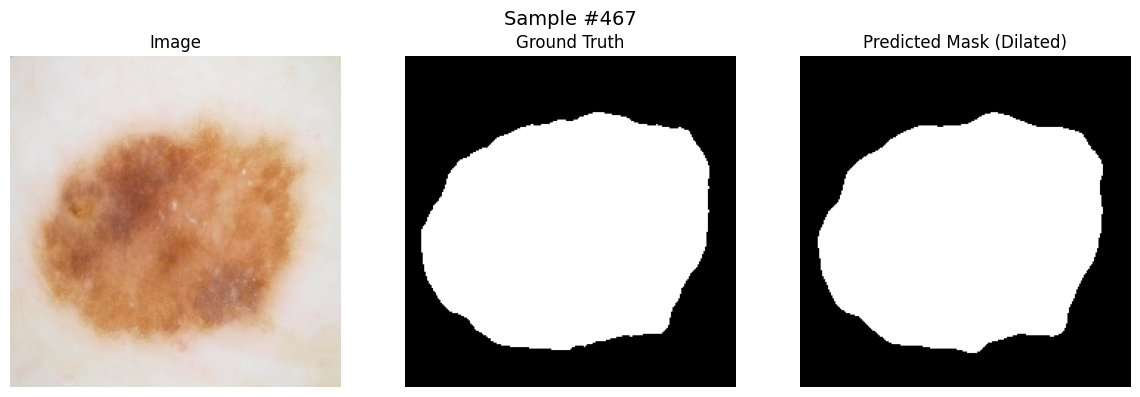

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


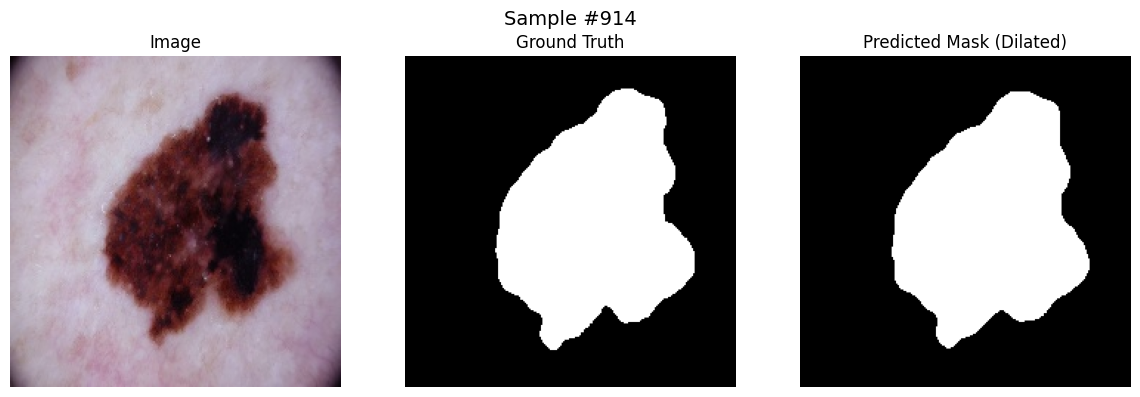

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


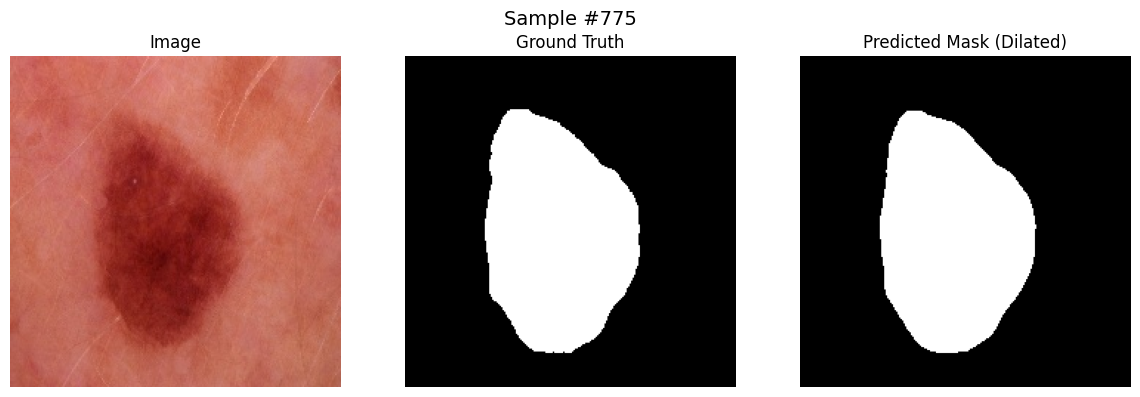

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


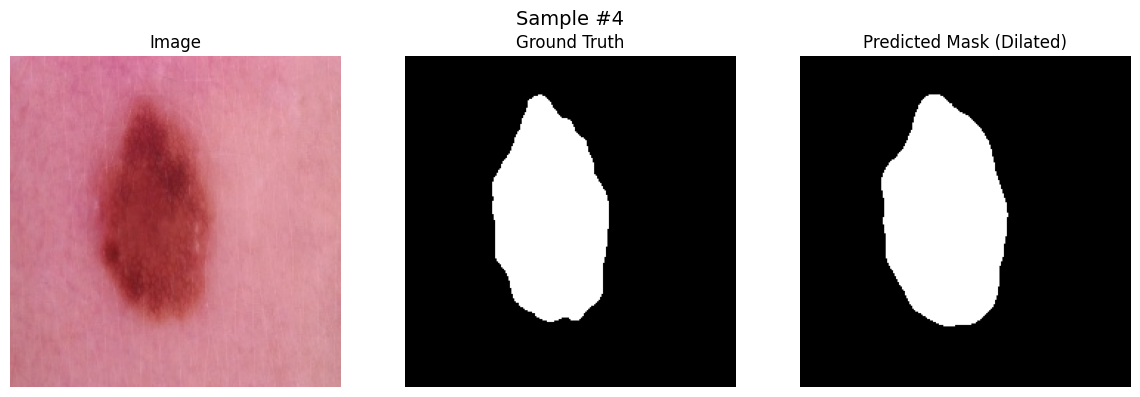

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


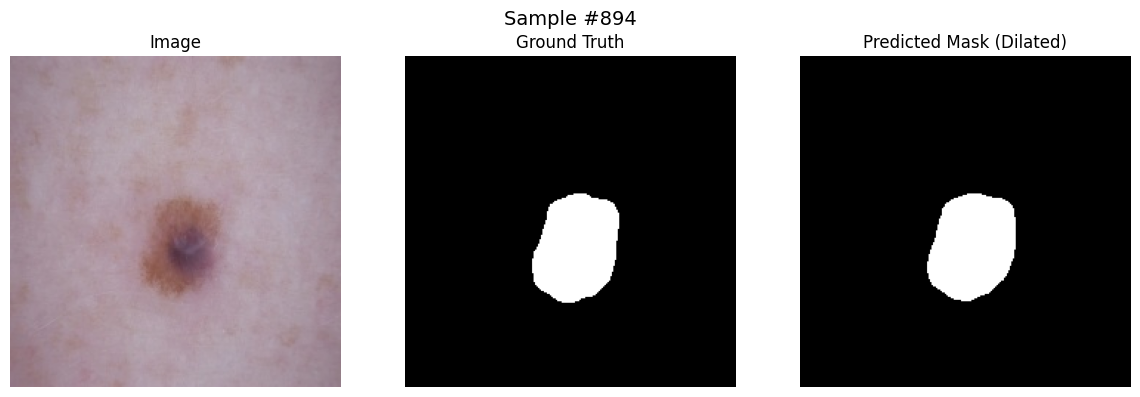

In [18]:
# Pick 3 samples from the test set
num_samples = 5
sample_indices = np.random.choice(len(test_images), num_samples, replace=False)

for i in sample_indices:
    image = test_images[i]  
    true_mask = test_masks[i]  

    # Predict the mask
    pred_mask = model.predict(np.expand_dims(image, axis=0))[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)

    # Smooth the mask (optional)
    kernel_open = np.ones((1, 1), np.uint8)
    smoothed_mask = cv2.morphologyEx(pred_mask, cv2.MORPH_OPEN, kernel_open)

    # Optional: Apply light blur and re-threshold
    blurred = cv2.GaussianBlur(smoothed_mask.astype(np.float32), (5, 5), 0)
    final_mask = (blurred > 0.5).astype(np.uint8)

    # Expand the mask (dilate) to include more skin around the lesion
    #kernel_dilate = np.ones((7, 7), np.uint8)  # Can try (7,7) for bigger margin
    #dilated_mask = cv2.dilate(final_mask, kernel_dilate, iterations=1)

    kernel_dilate = np.ones((1,1), np.uint8)
    dilated_mask = cv2.dilate(final_mask, kernel_dilate, iterations=1)

    # Plot the results
    plt.figure(figsize=(12, 4))
    plt.suptitle(f"Sample #{i}", fontsize=14)

    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(true_mask.squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask (Dilated)")
    plt.imshow(dilated_mask.squeeze(), cmap='gray')  #  using expanded mask
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# Overlay Function


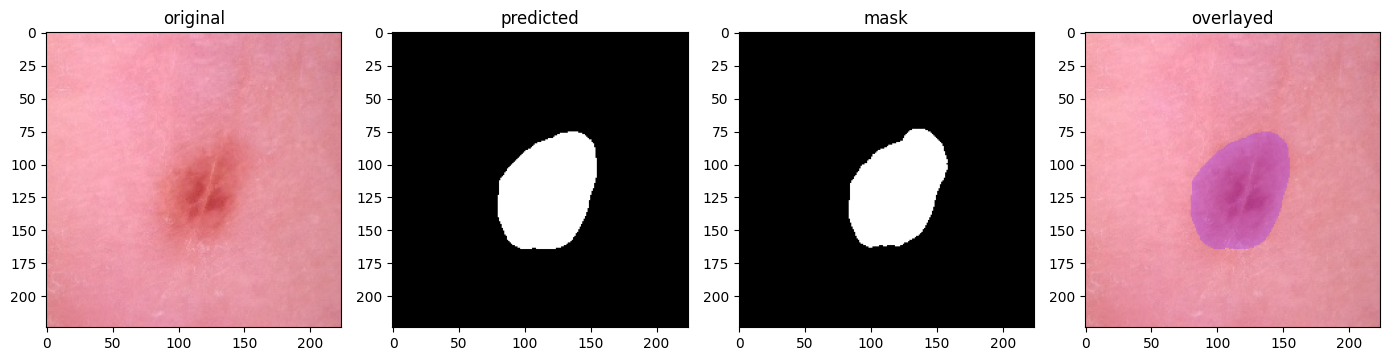

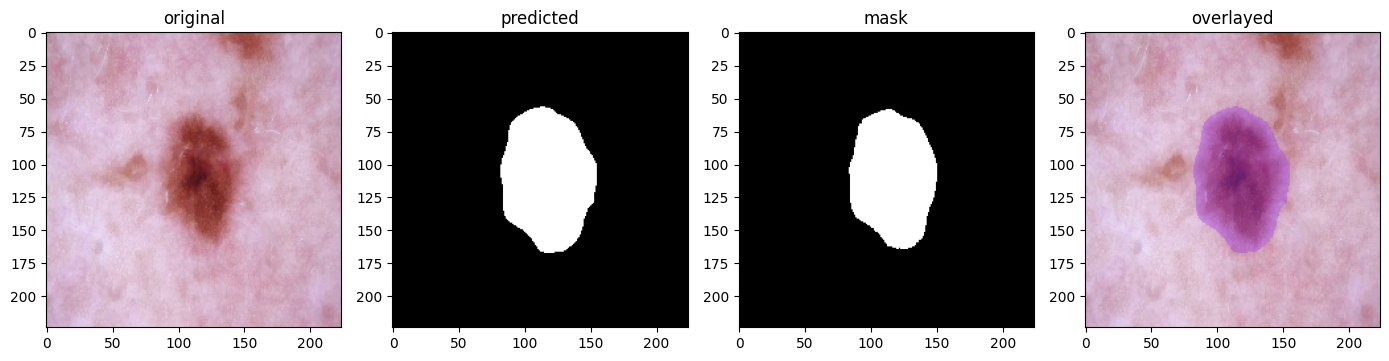

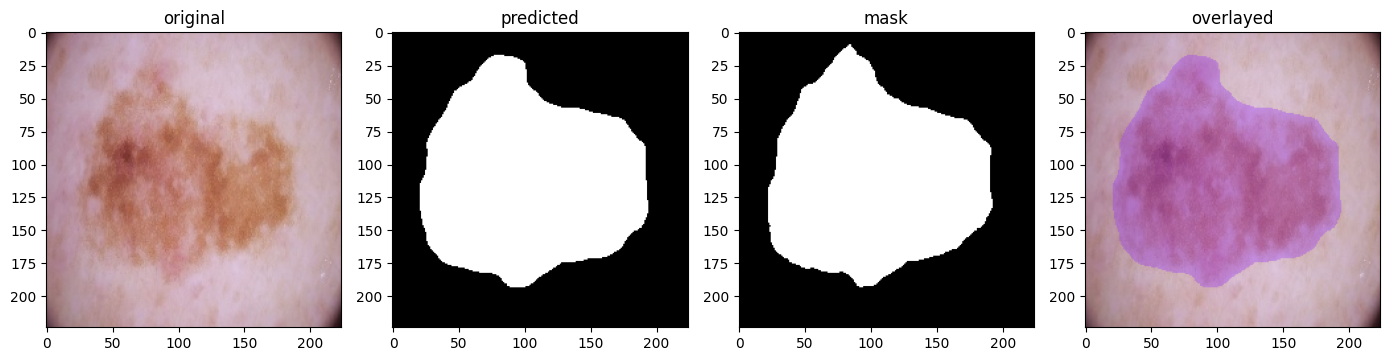

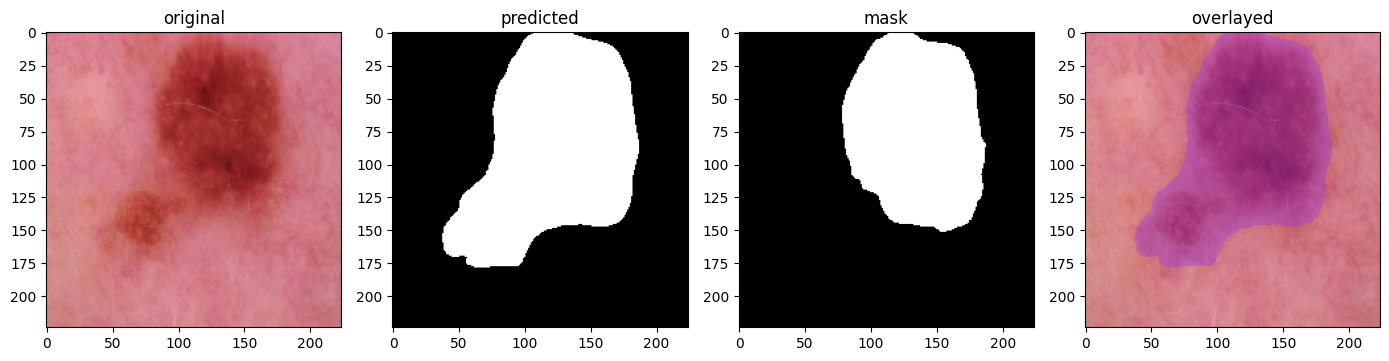

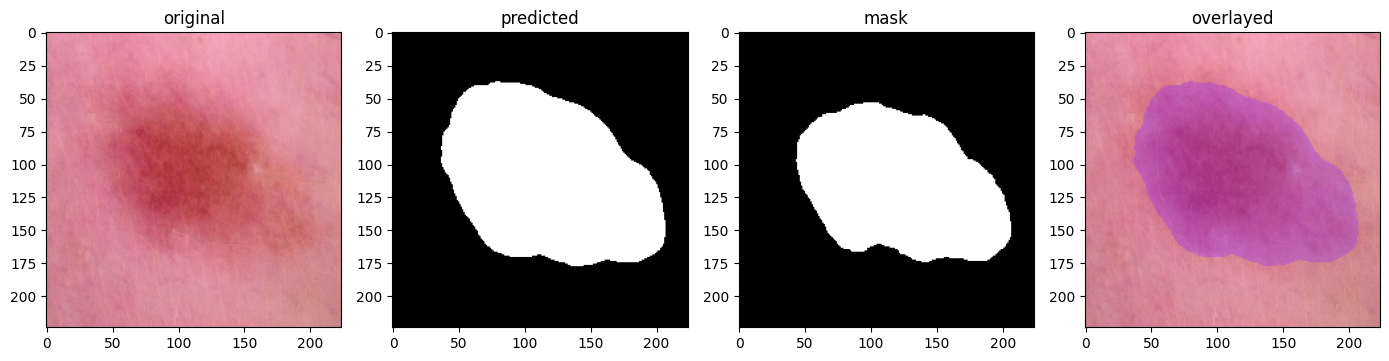

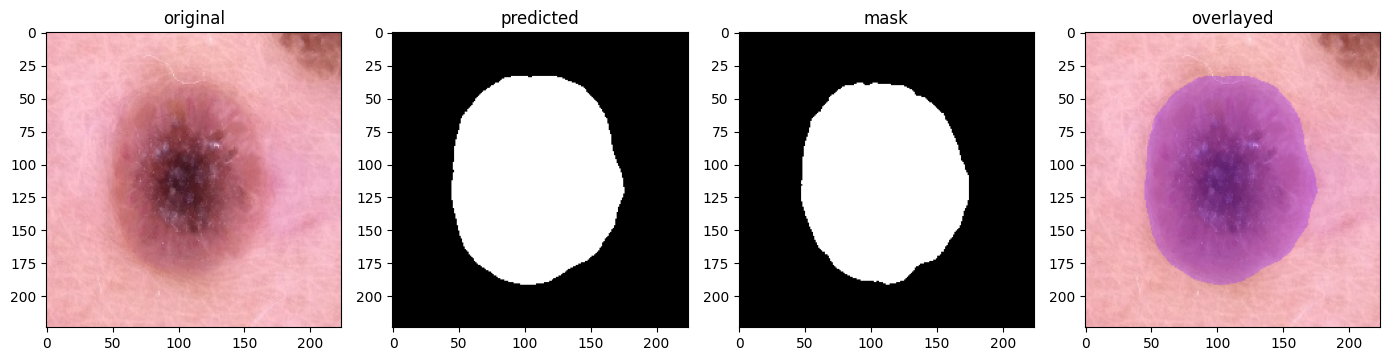

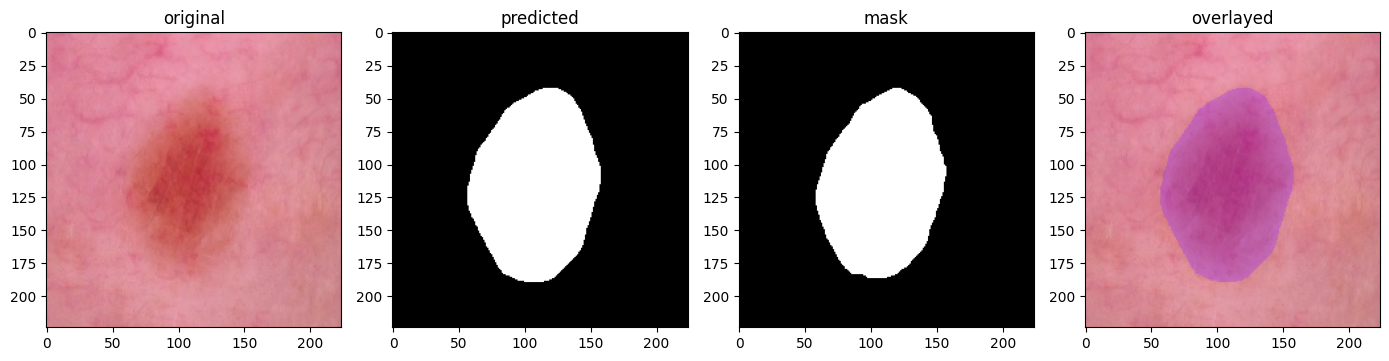

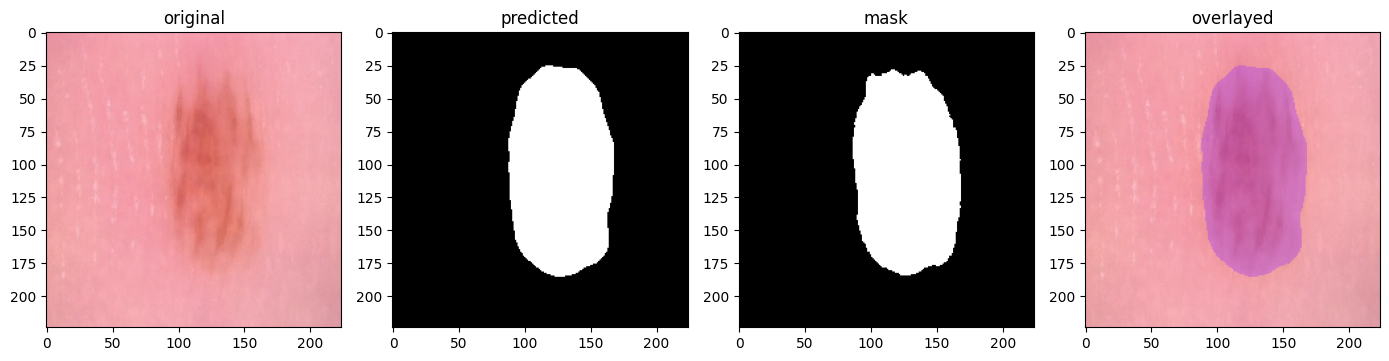

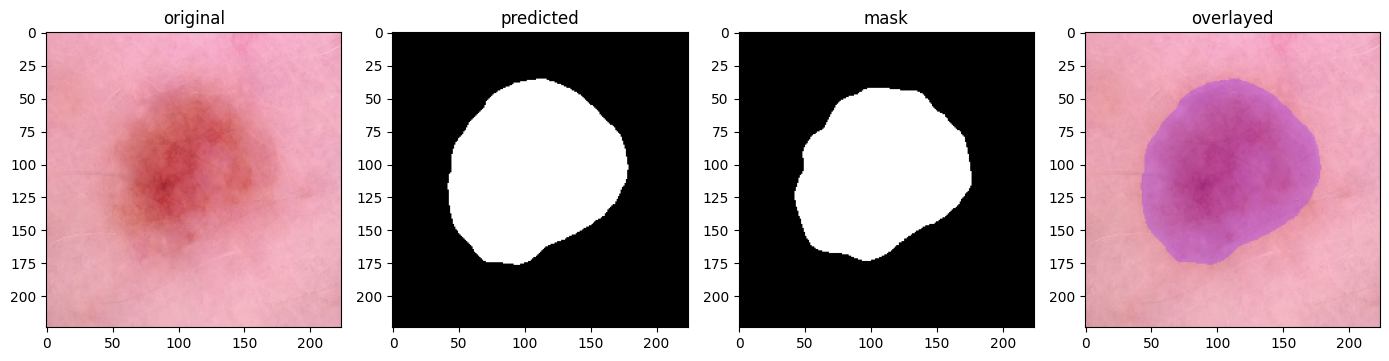

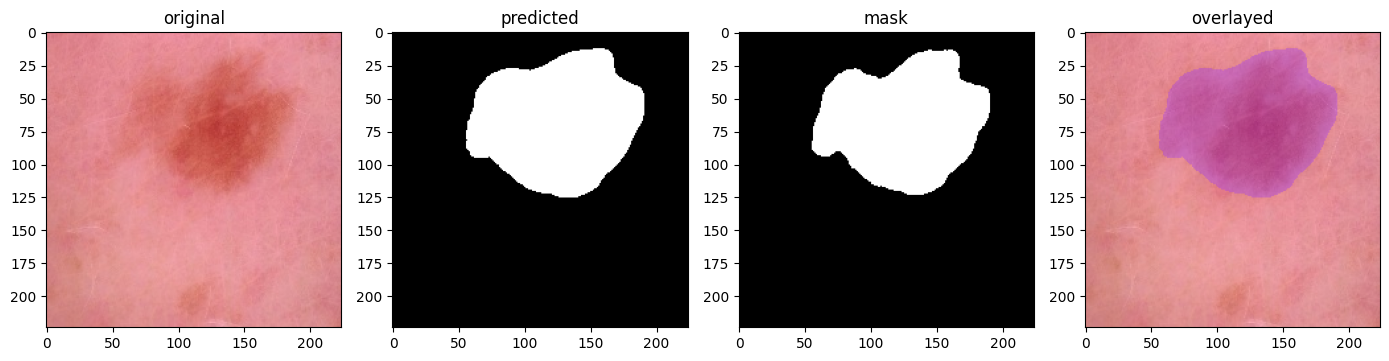

In [19]:
# ---------- Helpers ----------
def to_float01(img):
    img = img.astype(np.float32)
    if img.max() > 1.0:  # handle 0-255 inputs
        img /= 255.0
    return np.clip(img, 0.0, 1.0)

def overlay_purple(image, mask, dilate_iterations=1, alpha=0.35):
    """
    Overlay a purple mask on the image.
    image: HxWx3 (RGB), any range; mask: HxW or HxWx1 in {0,1}.
    """
    image = to_float01(image)
    mask = np.squeeze(mask).astype(np.uint8)

    kernel = np.ones((1, 1), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=dilate_iterations)

    # purple in [0,1] ~ (R=0.6, G=0.2, B=1.0)
    color = np.array([0.6, 0.2, 1.0], dtype=np.float32)
    overlay_rgb = np.zeros_like(image, dtype=np.float32)
    overlay_rgb[..., 0] = color[0] * mask
    overlay_rgb[..., 1] = color[1] * mask
    overlay_rgb[..., 2] = color[2] * mask

    mask3 = np.repeat(mask[..., None], 3, axis=-1).astype(np.float32)
    blended = image * (1 - alpha * mask3) + overlay_rgb * (alpha * mask3)
    return np.clip(blended, 0, 1)

# ---------- Visualize ----------
num_examples = 10
for i in range(num_examples):
    idx = np.random.randint(0, len(test_images))
    image = test_images[idx]
    true_mask = (np.squeeze(test_masks[idx]) > 0.5).astype(np.uint8)

    # Predict mask
    pred = model.predict(np.expand_dims(image, axis=0), verbose=0)[0]
    pred = (np.squeeze(pred) > 0.5).astype(np.uint8)

    # Smooth / refine mask
    kernel = np.ones((1, 1), np.uint8)
    pred = cv2.morphologyEx(pred, cv2.MORPH_OPEN, kernel)
    pred = cv2.dilate(pred, np.ones((3, 3), np.uint8), iterations=1)

    # Figure with ticks
    plt.figure(figsize=(14, 4))

    # Original
    plt.subplot(1, 4, 1)
    plt.imshow(to_float01(image))
    plt.title("original")

    # Predicted
    plt.subplot(1, 4, 2)
    plt.imshow(pred, cmap="gray", vmin=0, vmax=1)
    plt.title("predicted")

    # Ground-truth mask
    plt.subplot(1, 4, 3)
    plt.imshow(true_mask, cmap="gray", vmin=0, vmax=1)
    plt.title("mask")

    # Overlayed
    plt.subplot(1, 4, 4)
    plt.imshow(overlay_purple(image, pred, dilate_iterations=0, alpha=0.35))
    plt.title("overlayed")

    # Save with ticks visible
    plt.tight_layout()
    plt.savefig(f"unet_example_{i+1}_with_ticks.png", dpi=300, bbox_inches="tight")
    plt.show()


# Save Model

In [20]:
#model.save("/kaggle/working/my_model.h5")

## Clear kaggle output folder if thing gets messy

In [21]:
#rm -rf /kaggle/working/*